In [24]:
import jax
import jax.numpy as jnp

import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott import datasets
from ott.geometry import pointcloud
from ott.neural.methods import neuraldual
from ott.neural.networks import potentials
from ott.tools import sinkhorn_divergence

import optax, flax
from flax import linen as nn

from ott import datasets
from ott.neural.methods import neuraldual
from ott.neural.networks import icnn

from utils import *
import h5py
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

import jax 
gpus = [d for d in jax.devices() if d.platform == 'gpu']
print("GPUs:", gpus)


GPUs: [CudaDevice(id=0)]


In [25]:
train_dataloader = JAXDualH5DataLoader(
    'data/predictions/QGPythiaTrain/sample_0.h5',
    'data/predictions/QGHerwigTrain/sample_0.h5',
    source_key='latn_1', 
    target_key='latn_1',
    batch_size=64, 
    shuffle=True, 
    seed=42,
    prefetch_size=2,
)

valid_dataloader = JAXDualH5DataLoader(
    'data/predictions/QGPythiaVal/sample_0.h5',
    'data/predictions/QGHerwigVal/sample_0.h5',
    source_key='latn_1', 
    target_key='latn_1',
    batch_size=64, 
    shuffle=True, 
    seed=42,
    prefetch_size=2,
)



Using 1 devices for prefetching.
Using 1 devices for prefetching.


In [26]:
it_s = iter(train_dataloader.source_iter)
sb = next(it_s)
print("source batch shape: should be (ndev, batchsize/ndev, #latent features):", np.asarray(sb).shape)  # expect (ndev, per_dev, ...)

it_t = iter(train_dataloader.target_iter)
tb = next(it_t)
print("target batch shape: should be (ndev, batchsize/ndev, #latent features):", np.asarray(tb).shape)  # same structure

source batch shape: should be (ndev, batchsize/ndev, #latent features): (64, 1)
target batch shape: should be (ndev, batchsize/ndev, #latent features): (64, 1)


In [27]:
optimizer_f = optax.adam(learning_rate=1e-3, b1=0.5, b2=0.9, eps=1e-8)
optimizer_g = optax.adam(learning_rate=1e-3, b1=0.5, b2=0.9, eps=1e-8)



In [28]:
#hotfixes for ICNNs?

class ScalarICNN(icnn.ICNN):
    def __call__(self, x):
        y = super().__call__(x)      # (B,1) or (1,)
        return jnp.squeeze(y, axis=-1)  # (B,) or ()

class VmapICNN(icnn.ICNN):
    """ICNN with scalar-per-sample value and vmapped gradient (no axis-specific squeeze)."""

    @staticmethod
    def _scalarize(y):
        # y is (1,1) or (1,) — flatten and take the single element -> ()
        return jnp.ravel(y)[0]

    def potential_value_fn(self, params, other_potential_value_fn=None):
        # Scalar value for ONE sample (d,) -> ()
        def value_one(x):
            y = self.apply({"params": params}, x[None, ...])  # (1,1) or (1,)
            return self._scalarize(y)                          # scalar ()

        # Batched value: (B,d) -> (B,)
        def value(x):
            return jax.vmap(value_one)(x) if x.ndim == 2 else value_one(x)
        return value

    def potential_gradient_fn(self, params):
        # Scalar value for ONE sample
        def value_one(x):
            y = self.apply({"params": params}, x[None, ...])  # (1,1) or (1,)
            return self._scalarize(y)                          # ()

        grad_one = jax.grad(value_one)                         # (d,) -> (d,)

        def grad(x):
            return jax.vmap(grad_one)(x) if x.ndim == 2 else grad_one(x)
        return grad

In [29]:

neural_f = icnn.ICNN(
    dim_hidden=[64, 64, 64, 64], 
    dim_data=1, 
    init_fn=nn.initializers.normal(),
    #pos_weights=True, 
    rectifier_fn=flax.linen.activation.softplus,
    act_fn=flax.linen.activation.celu,

)
neural_g = icnn.ICNN(
    dim_hidden=[64, 64, 64, 64], 
    dim_data=1, 
    init_fn=nn.initializers.normal(),
    #pos_weights=True, 
    rectifier_fn=flax.linen.activation.softplus,
    act_fn=flax.linen.activation.celu,


)

#neural_f = ScalarICNN(dim_hidden=[64, 64, 64, 64], dim_data=1, init_fn=nn.initializers.normal())
#neural_g = ScalarICNN(dim_hidden=[64, 64, 64, 64], dim_data=1, init_fn=nn.initializers.normal())

#neural_f = VmapICNN(dim_hidden=[64,64,64,64], dim_data=1)
#neural_g = VmapICNN(dim_hidden=[64,64,64,64], dim_data=1)

In [30]:
#set up main training objective 

neural_dual_solver = neuraldual.W2NeuralDual(
    1, 
    neural_f, 
    neural_g, 
    optimizer_f, 
    optimizer_g, 
    num_train_iters=200, 
    amortization_loss="objective",
    #conjugate_solver=None,
    num_inner_iters=1,

)


/fs/ddn/sdf/group/atlas/d/jkrupa/diff_prog/environment/miniconda3/envs/latent-calib/lib/python3.10/site-packages/ott/neural/methods/neuraldual.py:155: UserWarning: Setting of ICNN and the positive weights setting of the `W2NeuralDual` are not consistent. Proceeding with the `W2NeuralDual` setting, with positive weights being True.
  self.setup(


In [31]:
#check shapes , should be (ndev, per_dev, #latent features) for each batch
train_src_iter = normalize_for_ott(train_dataloader.source_iter)
train_tgt_iter = normalize_for_ott(train_dataloader.target_iter)
valid_src_iter = normalize_for_ott(valid_dataloader.source_iter)
valid_tgt_iter = normalize_for_ott(valid_dataloader.target_iter)
src = next(train_src_iter)
tgt = next(train_tgt_iter)
print(src.shape)         # 
print(tgt.shape)         # 
print(src[0,0].shape)    # should reduce to (#latent features,)
print(tgt[0,0].shape)    # should reduce to (#latent features,)

 step 0: batch (1, 64, 1) | dev0 (64, 1) | sample (1,)
 step 0: batch (1, 64, 1) | dev0 (64, 1) | sample (1,)
(1, 64, 1)
(1, 64, 1)
(1,)
(1,)


In [32]:
train_src_iter = train_dataloader.source_iter
train_tgt_iter = train_dataloader.target_iter
valid_src_iter = valid_dataloader.source_iter
valid_tgt_iter = valid_dataloader.target_iter

In [33]:
#run training
learned_potentials = neural_dual_solver(
    train_src_iter,
    train_tgt_iter,
    valid_src_iter,
    valid_tgt_iter,
)

100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


In [34]:
#make full validation dataset
samples_s = []
samples_t = []
it_s = iter(valid_dataloader.source_iter)
it_t = iter(valid_dataloader.target_iter)

for _ in range(10000):  # take 10 batches
    batch_s = next(it_s)
    batch_t = next(it_t)
    samples_s.append(np.asarray(batch_s).reshape(-1, batch_s.shape[-1]))
    samples_t.append(np.asarray(batch_t).reshape(-1, batch_t.shape[-1]))

data_source = np.concatenate(samples_s, axis=0)
data_target = np.concatenate(samples_t, axis=0)



In [35]:
x = learned_potentials.transport(data_source)
print(type(x))

<class 'jaxlib._jax.ArrayImpl'>


In [36]:
y = np.array(x)
y

array([[-5.7375491e-02],
       [ 8.8194344e+05],
       [ 6.7850944e+05],
       ...,
       [ 8.4205481e+05],
       [-5.4953525e+05],
       [ 8.2357335e-01]], shape=(640000, 1), dtype=float32)

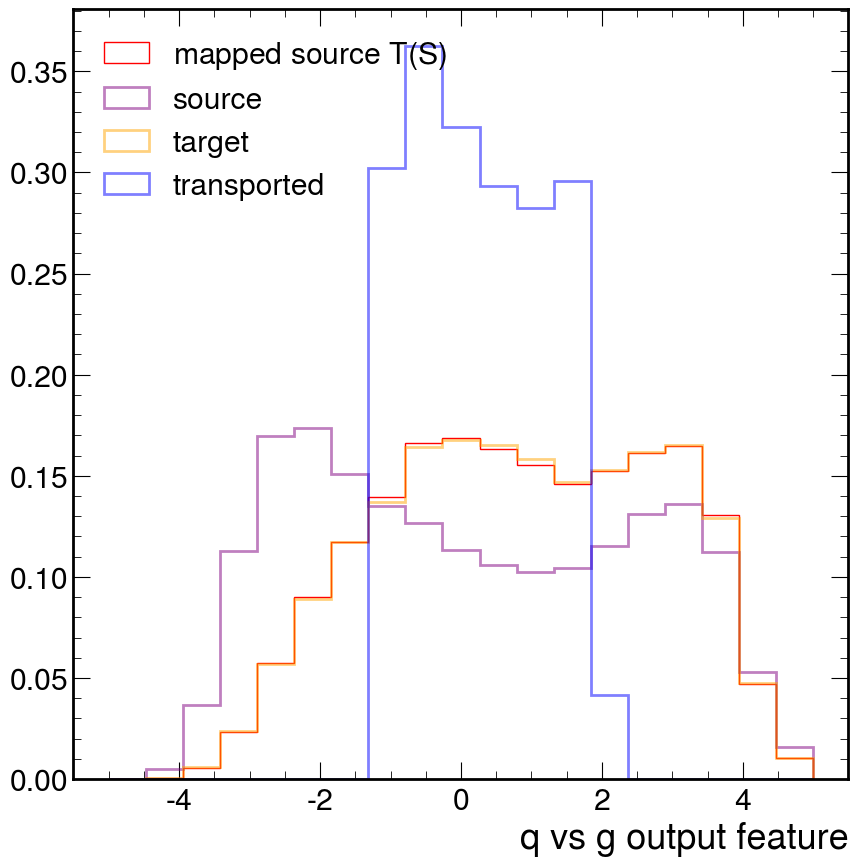

In [37]:
#fit a quantile map, plot transported source->target (on valid data), source, target
rng = np.random.default_rng(0)
src = np.asarray(data_source).ravel()
tgt = np.asarray(data_target).ravel()
perm_s = rng.permutation(len(src))
perm_t = rng.permutation(len(tgt))
S_tr, S_te = src[perm_s[: len(src)//2]], src[perm_s[len(src)//2:]]
T_tr, T_te = tgt[perm_t[: len(tgt)//2]], tgt[perm_t[len(tgt)//2:]]

# fit map on training halves
T_S2T = fit_quantile_map_S2T(S_tr, T_tr)

# apply to held-out source
Z = T_S2T(S_te)  # mapped source (should look like T_te)

plt.hist(Z,    bins=np.linspace(-5,5,20), histtype='step', color='red',   label='mapped source $T(S)$', density=True)
plt.hist(data_source,histtype='step',color='purple',linewidth=2,alpha=0.5, label='source',bins=np.linspace(-5,5,20), density=True)
plt.hist(data_target,histtype='step',color='orange',linewidth=2,alpha=0.5, label='target',bins=np.linspace(-5,5,20), density=True)
plt.hist(learned_potentials.transport(data_source),histtype='step',color='blue',linewidth=2,alpha=0.5, label='transported',bins=np.linspace(-5,5,20), density=True)

plt.xlabel('q vs g output feature')
plt.legend()

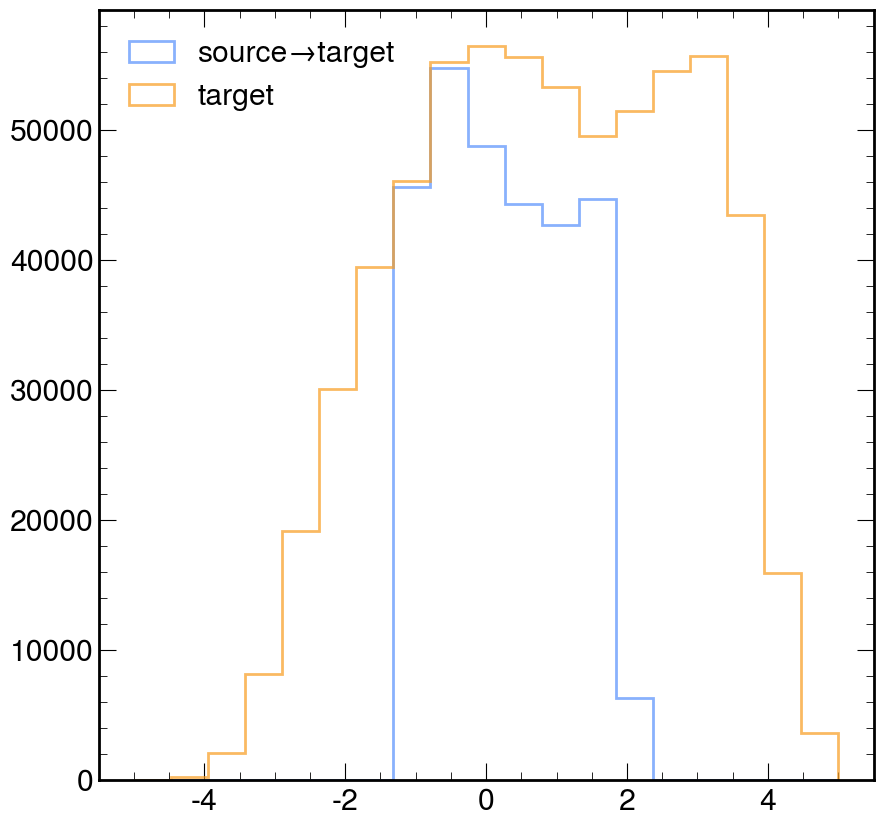

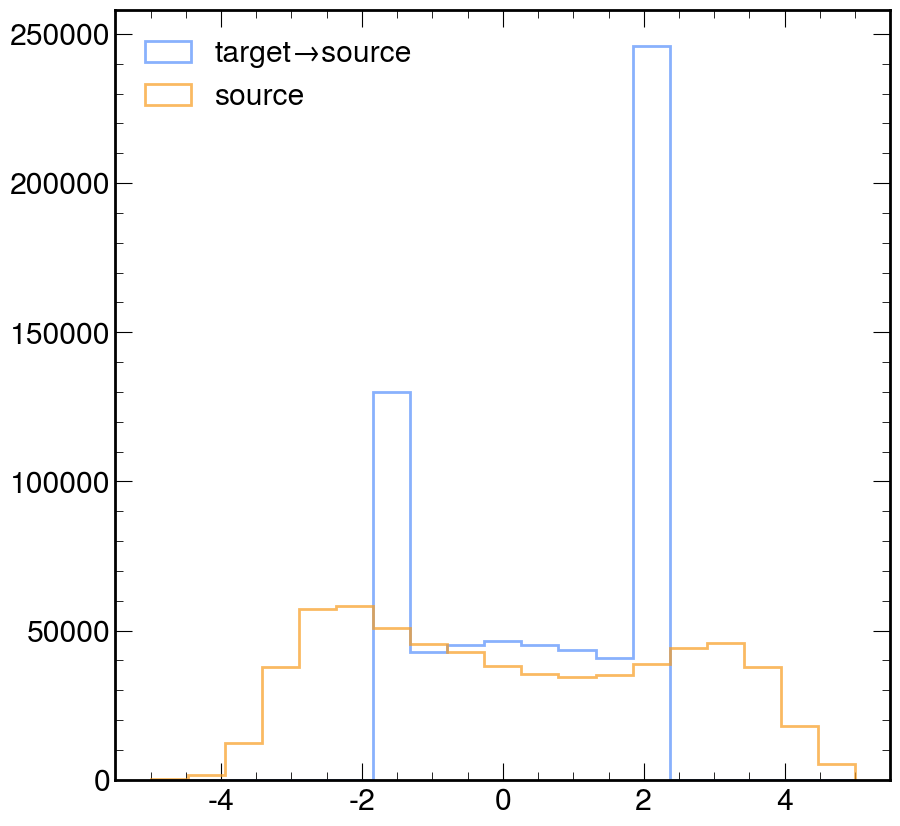

In [38]:
def get_maps(pots):
    # Try to grab the vmapped gradients in a version-agnostic way
    if hasattr(pots, "f_grad") and hasattr(pots, "g_grad"):
        f_grad, g_grad = pots.f_grad, pots.g_grad
    elif hasattr(pots, "transport"):  # some versions let you pick a direction
        # wrap to explicit maps
        f_grad = lambda x: pots.transport(x, forward=True)   # source→target
        g_grad = lambda x: pots.transport(x, forward=False)  # target→source
    elif hasattr(pots, "transport_source") and hasattr(pots, "transport_target"):
        f_grad, g_grad = pots.transport_source, pots.transport_target
    else:
        raise RuntimeError("Can't find gradient/transport methods on learned_potentials.")
    return f_grad, g_grad

f_grad, g_grad = get_maps(learned_potentials)

# compute both directions on your validation splits
s2t = f_grad(data_source)   # source → target (what you want to compare to target)
t2s = g_grad(data_target)   # target → source (should match source)

# Plot: which one aligns?
bins = np.linspace(-5, 5, 20)
plt.hist(s2t,        histtype='step', linewidth=2, alpha=0.7, label='source→target', bins=bins)
plt.hist(data_target,histtype='step', linewidth=2, alpha=0.7, label='target',          bins=bins)
plt.legend(); #plt.title("Check forward map")

plt.figure()
plt.hist(t2s,        histtype='step', linewidth=2, alpha=0.7, label='target→source', bins=bins)
plt.hist(data_source,histtype='step', linewidth=2, alpha=0.7, label='source',        bins=bins)
plt.legend(); #plt.title("Check backward map")

[-4.6150494  -4.3325906  -4.281464   -4.281464   -4.280136   -4.280136
 -4.204797   -4.1781397  -4.151519   -4.1310515  -4.111249   -4.056808
 -4.021965   -3.9621303  -3.9031732  -3.8530462  -3.7924159  -3.7438636
 -3.6817393  -3.6103442  -3.5529528  -3.4825785  -3.4290159  -3.3644044
 -3.2999663  -3.2362034  -3.1626391  -3.081885   -3.0077033  -2.9324136
 -2.860174   -2.7868805  -2.7189324  -2.643892   -2.5698745  -2.4937704
 -2.421322   -2.3452585  -2.267834   -2.187468   -2.1046524  -2.0282297
 -1.9495625  -1.872755   -1.797828   -1.721569   -1.6455886  -1.5719053
 -1.5007437  -1.4283354  -1.3565867  -1.2870471  -1.2146356  -1.1481411
 -1.0806531  -1.0154823  -0.9533343  -0.88974166 -0.82934785 -0.77128685
 -0.71782184 -0.6618096  -0.61364424 -0.5663721  -0.51666176 -0.47222012
 -0.42299575 -0.3771956  -0.3286122  -0.2833375  -0.23741242 -0.19586483
 -0.15263715 -0.10984416 -0.06772549 -0.02758996  0.0144491   0.05512114
  0.09712668  0.1356412   0.17594479  0.21550678  0.2572341   

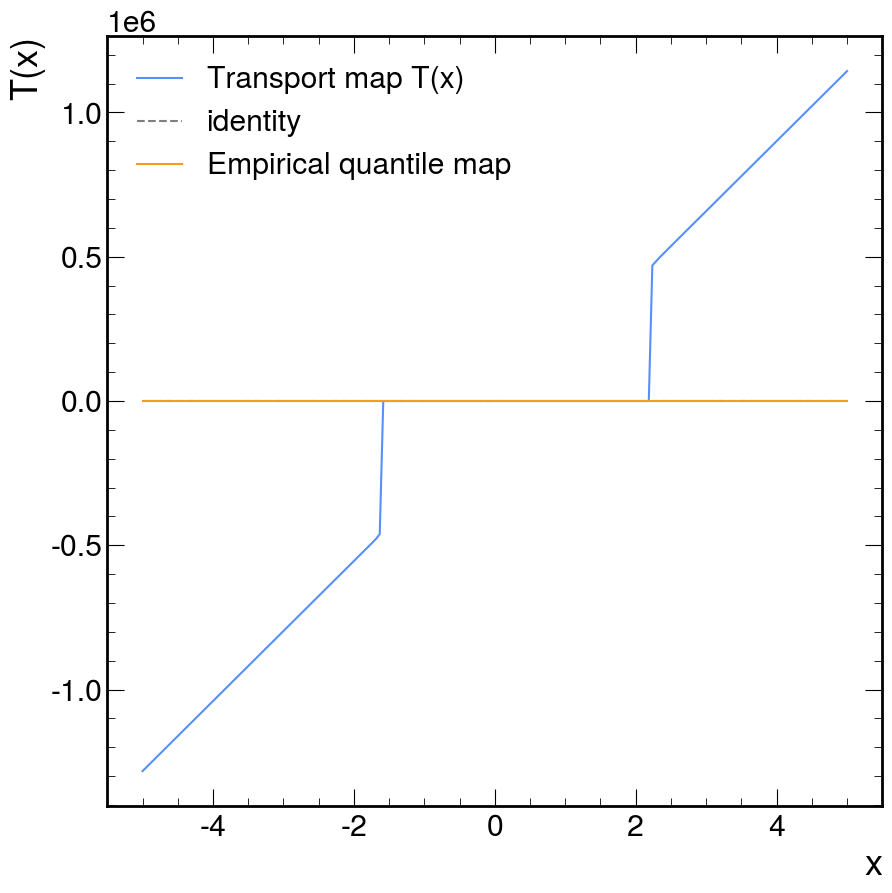

In [42]:
def empirical_quantile_map(x_grid, src, tgt):
    # src,tgt: (N,1) arrays; x_grid: (M,1)
    import numpy as np
    src = np.asarray(src).ravel()
    tgt = np.asarray(tgt).ravel()
    xg  = np.asarray(x_grid).ravel()
    s_q = np.argsort(src)
    F_s = np.searchsorted(np.sort(src), xg, side="right") / len(src)
    qs  = np.clip((F_s * (len(tgt)-1)).astype(int), 0, len(tgt)-1)
    Tstar = np.sort(tgt)[qs]
    return Tstar  # shape (M,)


# pick the right map: f_grad should be source→target
f_grad, g_grad = get_maps(learned_potentials)  # as in previous snippet

# build a 1D grid over the support of your data
x_grid = np.linspace(-5, 5, 200).reshape(-1, 1)   # (200, 1)

# compute transported points
T_x = f_grad(x_grid)   # shape (200, 1)

Tstar = empirical_quantile_map(x_grid, data_source, data_target)
print(Tstar)
# plot T(x) vs x
plt.figure()
plt.plot(x_grid, T_x, label="Transport map T(x)")
plt.plot(x_grid, x_grid, 'k--', alpha=0.5, label="identity")
plt.plot(x_grid, Tstar, label="Empirical quantile map")
plt.xlabel("x")
plt.ylabel("T(x)")
plt.legend()
plt.show()